In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [6]:
data = pd.read_csv('ARIMA.csv',parse_dates=['Datetime'],index_col=['Datetime'],)
monthly_data = data.resample('MS').mean()
print(data.head())
print(data.dtypes)
print(monthly_data.head())

                      Value
Datetime                   
2006-01-01 00:00:00  5957.0
2006-01-01 01:00:00  5837.0
2006-01-01 02:00:00  5592.0
2006-01-01 03:00:00  5383.0
2006-01-01 04:00:00  5201.0
Value    float64
dtype: object
                  Value
Datetime               
2006-01-01  6504.637097
2006-02-01  6547.453869
2006-03-01  6315.047106
2006-04-01  5660.704167
2006-05-01  5548.071237


In [7]:
monthly_data.index

DatetimeIndex(['2006-01-01', '2006-02-01', '2006-03-01', '2006-04-01',
               '2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01',
               '2006-09-01', '2006-10-01',
               ...
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01'],
              dtype='datetime64[ns]', name='Datetime', length=164, freq='MS')

In [8]:
ts=monthly_data["Value"]

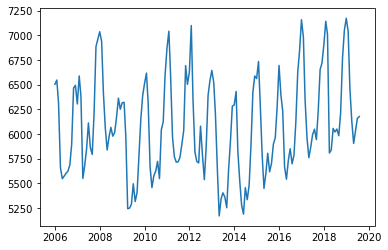

In [9]:
plt.plot(ts)

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

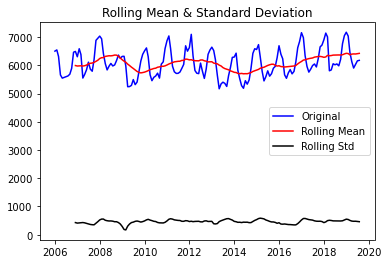

Results of Dickey-Fuller Test:
Test Statistic                  -2.332816
p-value                          0.161602
#Lags Used                      13.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


In [11]:
test_stationarity(ts)

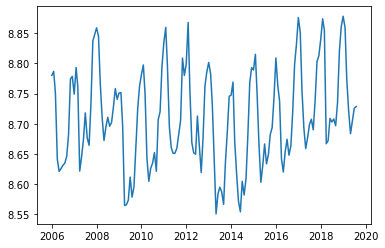

In [13]:
ts_log = np.log(ts)
plt.plot(ts_log)

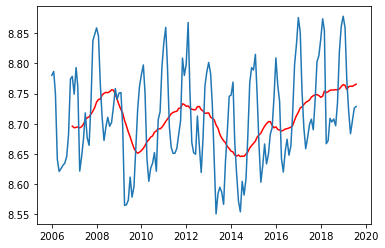

In [14]:
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()

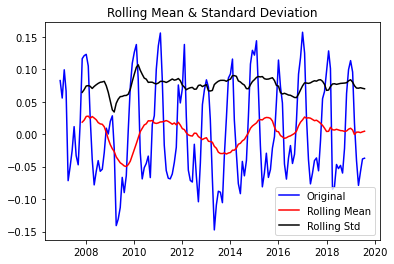

Results of Dickey-Fuller Test:
Test Statistic                  -4.020808
p-value                          0.001305
#Lags Used                      13.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


In [15]:
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)
test_stationarity(sub_ts)

In [16]:
ts_log

Datetime
2006-01-01    8.780271
2006-02-01    8.786832
2006-03-01    8.750690
2006-04-01    8.641304
2006-05-01    8.621206
                ...   
2019-04-01    8.721001
2019-05-01    8.683600
2019-06-01    8.704759
2019-07-01    8.725848
2019-08-01    8.728669
Freq: MS, Name: Value, Length: 164, dtype: float64

In [17]:
from statsmodels.tsa.stattools import acf, pacf

In [18]:
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

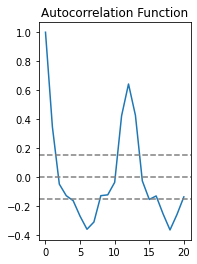

In [19]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [20]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: 0.3647')

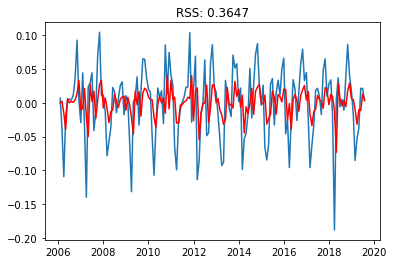

In [28]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [22]:
preds = pd.Series(results_AR.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print (preds_cumsum.head())

Datetime
2006-02-01   -0.000278
2006-03-01    0.001803
2006-04-01   -0.014482
2006-05-01   -0.052720
2006-06-01   -0.040447
Freq: MS, dtype: float64


Text(0.5, 1.0, 'ARIMA MODEL, RMSE: 441.8520')

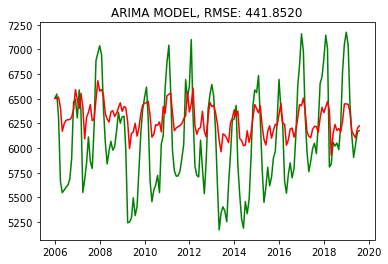

In [41]:
preds_ARIMA = np.exp(preds_log)
plt.plot(ts,color="green")
plt.plot(preds_ARIMA,color="red")
plt.title('ARIMA MODEL, RMSE: %.4f'% np.sqrt(sum((preds_ARIMA-ts)**2)/len(ts)))